In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

[Text(1, 0, 'jan'),
 Text(2, 0, 'feb'),
 Text(3, 0, 'mar'),
 Text(4, 0, 'apr'),
 Text(5, 0, 'may'),
 Text(6, 0, 'jun'),
 Text(7, 0, 'jul')]

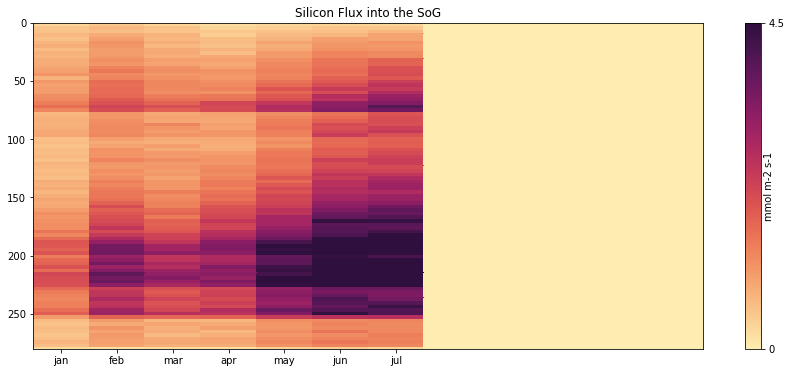

In [59]:
#SILICON FLUX

str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul']#, 'aug', 'sep', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7]#,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

depths = np.array([])
salts = np.array([])
transports = np.array([])
month = np.array([])

time = mydata.init_t[-1]

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    for section in sections:
        depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
        salts = np.append(salts, mydata.final_salt[(mydata.final_section==section)])
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
        month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),int_mo[i]))
        
month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, salts, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= H1.T * H.statistic.T * float(sum(transports))
np.nan_to_num(H_final, nan=0, copy=False)

vmax = 17000 #something must be wrong, the flux is waayyyyy too high

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.matter
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, 4.5]) #kinda arbitrary rn until i can fix the calc problem
cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_title('Silicon Flux into the SoG')
ax.set_xticks(int_mo)
ax.set_xticklabels(str_mo)

[Text(1, 0, 'jan'),
 Text(2, 0, 'feb'),
 Text(3, 0, 'mar'),
 Text(4, 0, 'apr'),
 Text(5, 0, 'may'),
 Text(6, 0, 'jun'),
 Text(7, 0, 'jul')]

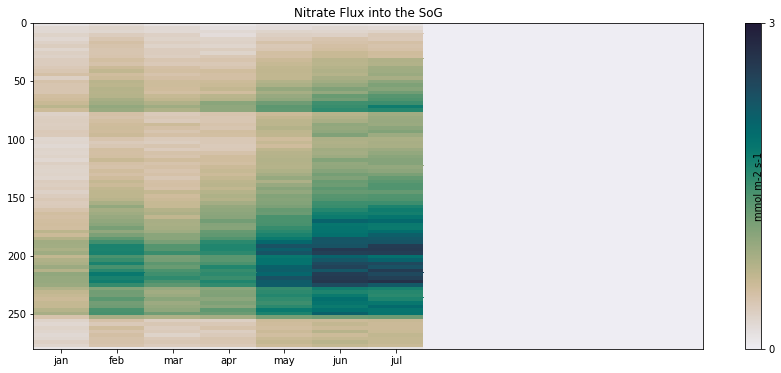

In [61]:
#NITRATE FLUX

str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul']#, 'aug', 'sep', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7]#,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

depths = np.array([])
tracer = np.array([])
transports = np.array([])
month = np.array([])

time = mydata.init_t[-1]

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    for section in sections:
        depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
        tracer = np.append(tracer, mydata.final_temp[(mydata.final_section==section)])
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
        month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),int_mo[i]))
        
month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

H = binned_statistic_2d(month, depths, tracer, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
H_final= H1.T * H.statistic.T * float(sum(transports))
np.nan_to_num(H_final, nan=0, copy=False)

vmax = 15000 #something must be wrong, the flux is waayyyyy too high

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.rain
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([0, vmax])
cb1.set_ticklabels([0, 3]) #kinda arbitrary rn until i can fix the calc problem
cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_title('Nitrate Flux into the SoG')
ax.set_xticks(int_mo)
ax.set_xticklabels(str_mo)

In [ ]:
# #SALINITY FLUX - dont have whole year of runs for this yet, do runs with carbon as the temperature tracer

# str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul']#, 'aug', 'sep', 'nov', 'dec']
# int_mo = [1,2,3,4,5,6,7]#,8,9,10,11,12]
# sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

# depths = np.array([])
# tracer = np.array([])
# transports = np.array([])
# month = np.array([])

# time = mydata.init_t[-1]

# for i in range(len(str_mo)):
#     file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1h/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
#     mydata = xr.open_dataset(file)
    
#     for section in sections:
#         depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
#         tracer = np.append(tracer, mydata.final_salt[(mydata.final_section==section)])
#         transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
#         month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),int_mo[i]))
        
# month_edge = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5]

# H1, xedges1, yedges1 = np.histogram2d(month, depths, bins=[month_edge,100] ,weights= transports, density= True)# vmax=vmax)

# H = binned_statistic_2d(month, depths, tracer, statistic=np.mean, bins=[month_edge,100])
# _, xedges, yedges = np.histogram2d(month, depths, bins = [month_edge,100])
   
# H_final= H1.T * H.statistic.T * float(sum(transports))
# np.nan_to_num(H_final, nan=0, copy=False)

# vmax = 15000 #something must be wrong, the flux is waayyyyy too high

# fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
# X, Y = np.meshgrid(xedges, yedges)
# cmap = cm.haline
# im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = 0, cmap=cmap)
# cb1 = fig.colorbar(im, ax=ax)
# cb1.set_ticks([0, vmax])
# cb1.set_ticklabels([0, 3.4]) #kinda arbitrary rn until i can fix the calc problem
# cb1.set_label('mmol m-2 s-1', labelpad=-20)
    
# ax.invert_yaxis()
# ax.set_ylim((280, 0))
# ax.set_title('Nitrate Flux into the SoG')
# ax.set_xticks(int_mo)
# ax.set_xticklabels(str_mo)

In [72]:
nitr_sum_for = np.array([])
sili_sum_for = np.array([])

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/forward_01'+str_mo[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    tracerN = np.array([])
    tracerS = np.array([])
    transports = np.array([])
    
    for section in sections:
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
        
        tracerN = np.append(tracerN, mydata.final_temp[(mydata.final_section==section)])
        tracerS = np.append(tracerS, mydata.final_salt[(mydata.final_section==section)])
    
    nitr_sum_for = np.append(nitr_sum_for,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_for = np.append(sili_sum_for,sum(tracerS*transports)/1000*(60.08/1000))   

In [74]:
nitr_sum_back = np.array([])
sili_sum_back = np.array([])

str_back = ['31jan','03mar','31mar','01may','31may','01jul','31jul','31aug','01oct','31oct','01dec','31dec']#need a seperate string for this as the backward run names are slightly less consistent

for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_tracers/backward_'+str_back[i]+'19/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    tracerN = np.array([])
    tracerS = np.array([])
    transports = np.array([])
    
    for section in sections:
        transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
        
        tracerN = np.append(tracerN, mydata.final_temp[(mydata.final_section==section)])
        tracerS = np.append(tracerS, mydata.final_salt[(mydata.final_section==section)])
    
    nitr_sum_back = np.append(nitr_sum_back,sum(tracerN*transports)/1000*(62.0049/1000))
    sili_sum_back = np.append(sili_sum_back,sum(tracerS*transports)/1000*(60.08/1000)) 

Text(0, 0.5, 'Tracer Flow into the SoG [kg/s]')

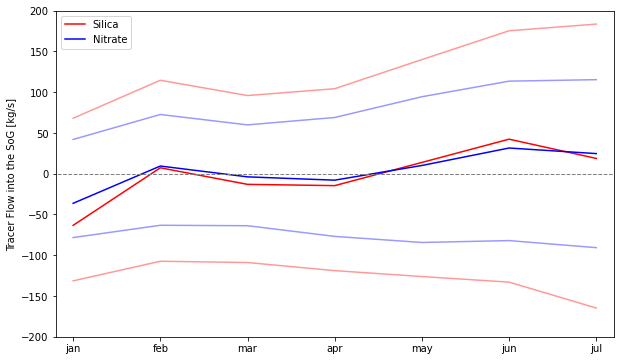

In [111]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(nitr_sum_for, c='b',alpha=0.4)
ax.plot(nitr_sum_back*-1,c='b',alpha=0.4)

ax.plot(sili_sum_for, c='r',alpha=0.4)
ax.plot(sili_sum_back*-1,c='r',alpha=0.4)

ax.plot(sili_sum_for-sili_sum_back,label='Silica', c='r')
ax.plot(nitr_sum_for-nitr_sum_back,label='Nitrate', c='b')

ax.plot(np.arange(-1,len(str_mo)+1), np.full(len(str_mo)+2,0), c='grey',ls='--',lw=1)

ax.legend()
ax.set_ylim([-200,200])
ax.set_xticks(np.arange(0,len(str_mo)))
ax.set_xticklabels(str_mo)
ax.set_xlim(-0.2,len(str_mo)-0.8)
ax.set_ylabel('Tracer Flow into the SoG [kg/s]')